# Dataset Challenges - Overview

* 59400 samples were collected and require heavy preprocessing
* 40 features per sample
* Thousands of missing values
* Mis-spellings & invalid values
* Some features are correlated
* Some features contain no useful information
* More than half of features are categorical. Some of them contain thousands unique values
* Imbalanced classes
* Multi-Class classification
* Test set contains unique categorical values that don't appear in the training set

# Importing Dataset

In [1]:
import pandas as pd

samples = pd.read_csv('train.csv')
samples

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [2]:
targets = pd.read_csv('targets.csv')
samples['targets'] = targets['status_group']
targets

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


# Class Distribution on World Map

"*Wikipedia*" reveals the subdivision of Tanzania. There are 30 regions, which are divided
into districts. District areas are composed of wards that consist of villages. On top of that,
several areas are divided by LGA (or Local Government Authority), which also groups villages
together based on proximity.

Text(0.5, 1.0, 'Targets Distribution on the map')

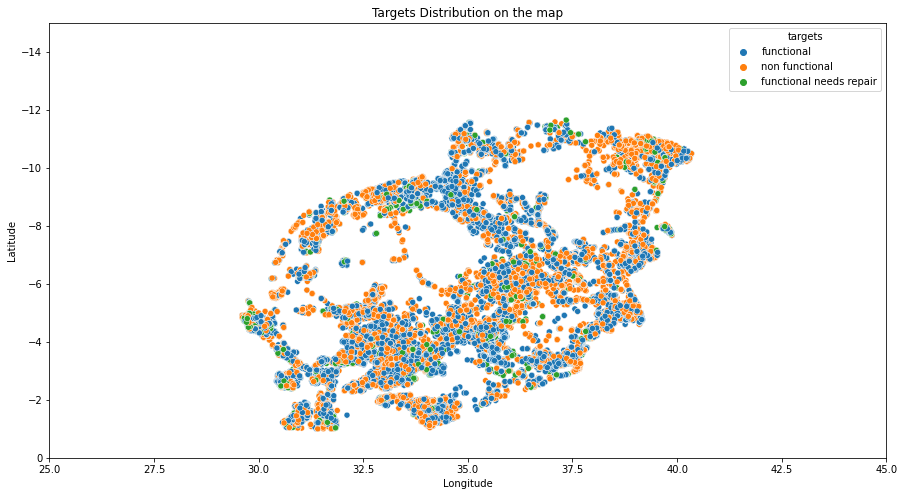

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.xlim(25, 45)
plt.ylim(0, -15)

ax = sns.scatterplot(data=samples, x='longitude', y='latitude', hue='targets')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Targets Distribution on the map')

Text(0.5, 1.0, 'Targets Distribution')

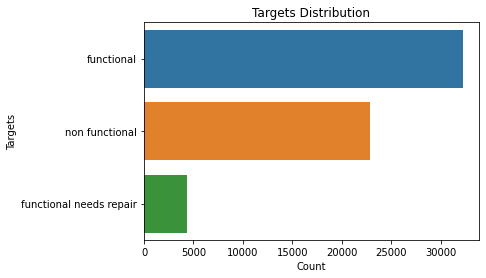

In [6]:
target_counts = samples['targets'].value_counts()
ax = sns.barplot(y=target_counts.index, x=target_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('Targets')
ax.set_title('Targets Distribution')

From a first look, it seems that there are **imbalanced classes** on this dataset. Only **10%** of the pumps
in this dataset need repair. Additionally, the `"functional needs repair"` class is the most important and less
appeared class on the map, so **imbalanced-learning** methods are required (e.g. **model calibration,
cost-sensitive-learning, synthetic data, etc.**).

# Amount TSH (Total Static Head)

The amount of water available to the water point. According to "Pumpfundamentals.com", "tsh" or "Total Static Head"
indicates the height at which the pump can raise up water. In other words, it indicates the elevation between the
surface of the reservoir and the point of discharge into the receiving tank. For this reason, it is impossible to have
a zero, because otherwise the use of pump would be pointless. By analyzing the dataset, **"*zero*" appears in 70% of the
samples. This indicates that `amount_tsh = 0` is actually a missing value.**

<AxesSubplot:>

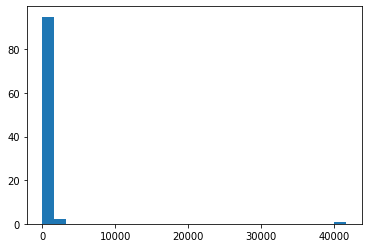

In [7]:
samples['amount_tsh'].value_counts().hist(bins=25, grid=False)

Directly trying to impute `amount_tsh` missing values would introduce bias, since most of the values are missing.
The naive approach would be to exclude the feature from the entire dataset or leave it the way it is.
**However, by further looking at the non-missing of this feature, lots of cases were found, on which the `amount_tsh`
of all pumps in the same subvillage have the same `amount_tsh` or have low standard deviation (std).**

Text(0.5, 1.0, 'STD of TSH per Subvillage')

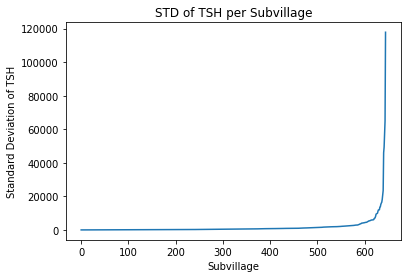

In [21]:
import numpy as np

stds = set()
for subvillage in samples['subvillage'].unique():
    subvillage_samples = samples[samples['subvillage'] == subvillage]
    if subvillage_samples.shape[0] > 1:
        non_zeros = subvillage_samples['amount_tsh'] > 0

        if sum(non_zeros):
            stds.add(np.std(subvillage_samples.loc[non_zeros, 'amount_tsh']))

stds = np.array(sorted(stds))
ax = sns.lineplot(x=np.arange(stds.shape[0]), y=stds)
ax.set_xlabel('Subvillage')
ax.set_ylabel('Standard Deviation of TSH')
ax.set_title('STD of TSH per Subvillage')

**By choosing a low std threshold, some of these values can be imputed, without changing the distribution.**
However, there are grouped pumps in each subvillage with very high std on these values, due to possible outliers.
No imputation can be done in such cases.

# Date Recorded

The inspection day of the pumps. According to "*ExpertAfrica.com*", there are two rainy seasons: the heaviest
rains that usually fall from March to May (**Spring**) and a shorter period of rain from September to November
(**Autumn**). The long dry season, with cooler temperatures, lasts from June to August (**Summer**), while the
short dry seasons starts from December to February (**Winter**). **This indicates that each sample are categorized
into 4 seasons:**

| Season     | Months               |
|------------|----------------------|
| ShortDry   | January - February   |
| LongRains  | March - May          |
| LongDry    | June - October       |
| ShortRains | November - December  |

Text(0.5, 1.0, 'Target Counts per Season')

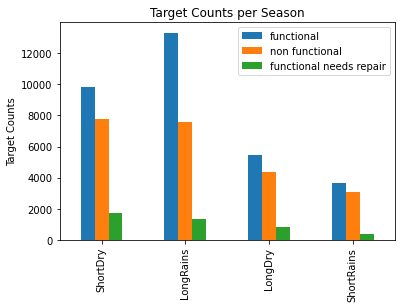

In [15]:
seasons = {
    1: 'ShortDry', 2: 'ShortDry',
    3: 'LongRains', 4: 'LongRains', 5: 'LongRains',
    6: 'LongDry', 7: 'LongDry', 8: 'LongDry', 9: 'ShortRains', 10: 'ShortRains',
    11: 'ShortRains', 12: 'ShortDry',
}

samples['season_recorded'] = pd.DatetimeIndex(samples['date_recorded']).month
samples['season_recorded'] = samples['season_recorded'].replace(seasons)

pump_season_distributions = pd.DataFrame({
    'ShortDry': samples[samples['season_recorded'] == 'ShortDry']['targets'].value_counts(),
    'LongRains': samples[samples['season_recorded'] == 'LongRains']['targets'].value_counts(),
    'LongDry': samples[samples['season_recorded'] == 'LongDry']['targets'].value_counts(),
    'ShortRains': samples[samples['season_recorded'] == 'ShortRains']['targets'].value_counts()
}).transpose()

ax = pump_season_distributions.plot.bar()
ax.set_ylabel('Target Counts')
ax.set_title('Target Counts per Season')

From the above graph, there are almost **40%** more functional pumps on **LongRains** season,
while the most **non-functional** pumps, as well as the pumps that need repair are recorded
on the **ShortDry** season.

# Construction Year

The construction year of the pump. This feature is used to compute the operation time of the pumps,
by the time they have been recorded. Logically, the longer the pumps operate, the more prone should
be to malfunction. However, **20709** values equal to zero, which indicate a missing value. Since any
of those pumps could be constructed at anytime, imputation is not an option. Instead, a new category
should be created for unknown construction year.

<AxesSubplot:title={'center':'Operation Time Distribution'}, xlabel='operation_time', ylabel='Count'>

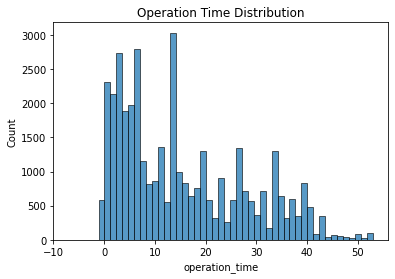

In [16]:
valid_dates = samples['construction_year'] != 0

construction_years = samples['construction_year'][valid_dates]
recorded_years = pd.DatetimeIndex(samples['date_recorded'][valid_dates]).year
operation_time_df = recorded_years - construction_years

ax = sns.histplot(operation_time_df)
ax.set_xlabel('operation_time')
ax.set_ylabel('Count')
ax.set_title('Operation Time Distribution')
ax

Aside from samples with `construction_year = 0`, the values of `construction_year` in some pumps
is greater than the actual `recorded_date` value. This means that the `construction_year` is probably
invalid. The **operation time of invalid dates should all equal to a specific value** (e.g. -1).


# Funder

The funder/organisation that donated the pumps. There are a couple of problems with this category.
Firstly, a portion of these values are missing (`nan`). Secondly, this feature contains lots of
character sequences like `'A', 'kk, kkk, ..., etc`, which doesn't make any sense nor provides any
information about the funders so that it can manually be corrected. Finally, there are lots of
misspellings or funders with similar namaes, such as `
'Oxfarm' and 'oxfam', 'Government of Tanzania and Central Government`, etc.`

<AxesSubplot:title={'center':'Funder Distribution'}, xlabel='funders', ylabel='Count'>

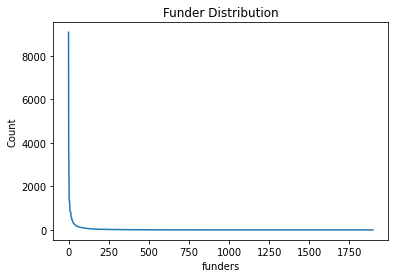

In [10]:
samples['funder'] = samples['funder'].astype(str)
funder_counts = samples['funder'].value_counts()

ax = sns.lineplot(x=np.arange(funder_counts.shape[0]), y=funder_counts)
ax.set_xlabel('funders')
ax.set_ylabel('Count')
ax.set_title('Funder Distribution')
ax

By looking at the plot below, it is obvious that this is a very poor distribution of the variable, as most of
the values have almost no appearance on the dataset. A good solution to this problem requires:

* Finding mis-spellings using a **string matching** function and update the column values
* Imputing "`nan`" as `unknown`
* Grouping similar organisations/funders together
* Transfering funders with low appearance frequency into "`other`" category

# Installer

The installer of the recorded pump. The same issues as `funder` are also found in this feature as well.

<AxesSubplot:title={'center':'Installer Distribution'}, xlabel='Installers', ylabel='Frequency'>

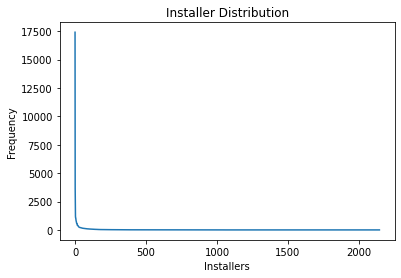

In [11]:
samples['installer'] = samples['installer'].astype(str)
installer_counts = samples['installer'].value_counts()

ax = sns.lineplot(x=np.arange(installer_counts.shape[0]), y=installer_counts)
ax.set_xlabel('Installers')
ax.set_ylabel('Frequency')
ax.set_title('Installer Distribution')
ax

# GPS Height

The GPS Height of the pump location or the height of the ground above sea. According to *worlddata.info*,
Tanzania is comparatively high at an average elevation of 1018 meters above sea level, so any `gps_height`
value is expected to be above zero. However, this dataset contains **1500 samples with gps_height less than
zero** and **34.4% equals to zero**, which are most likely to be missing values. Even though its information
might be inaccurate, it indicates the height of the location, so the information might still be useful.

<AxesSubplot:title={'center':'gps_height Distribution'}, xlabel='gps_height', ylabel='Count'>

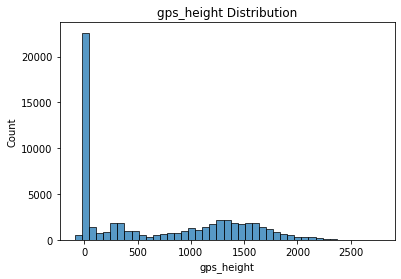

In [12]:
ax = sns.histplot(samples['gps_height'])
ax.set_xlabel('gps_height')
ax.set_ylabel('Count')
ax.set_title('gps_height Distribution')
ax

Just like "`amount_tsh`", similar and nearby pumps should be used to impute these values. If there are several
other water pumps in the same sub-village and not all of them have missing values, we can average their GPS height
values to impute the missing ones. Additionally, the "`gps_height`" variable seems to be location dependent, so if
there aren't any other pumps on the save subvillage, then the "`ward`" and even LGA features could be used as a location.

# Num Private

It is unknown what this feature is or what is its importance. Also, 99% of these values are zero,
so no importance was found in this feature and should be dropped from the dataset.

# Basin

The name of the basin (lake or river) from where the water is coming. **There are only 9 unique values, with no missing values.**
Even though the basin name is not directly associated with the pump operation, it could **indicate information about the water
quality**, such as pressure and softness, as well as environmental conditions*.

Text(0.5, 1.0, 'Basin Distribution')

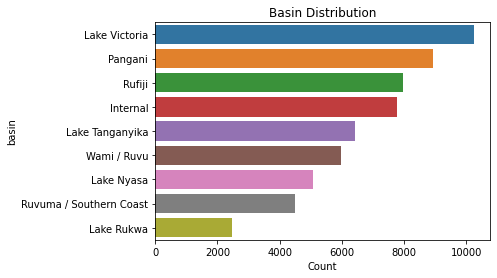

In [13]:
basin_counts = samples['basin'].value_counts()
ax = sns.barplot(y=basin_counts.index, x=basin_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('basin')
ax.set_title('Basin Distribution')

# Subvillage

The name of the geographical location of the pump. A large portion of the value counts equals to 1, which affects
the importance of this feature. **A few samples are missing (371)**, which **can be found `longitude and latitude`
values**, as well as `region and district area`. However, pumps of the same subvillage could be used for identifying
any missing values of nearby pumps.

# Region & Region Code

The region area of the pump. Regions are further divided by district areas. It contains no missing values
and useful information about the target distribution could be extracted from this variable.

<AxesSubplot:title={'center':'Region Distribution'}, xlabel='Count', ylabel='Region'>

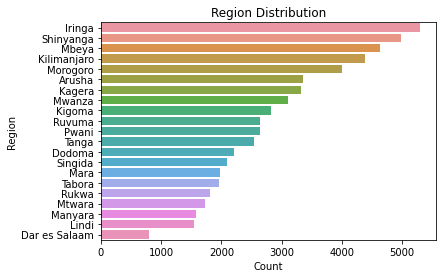

In [14]:
region_counts = samples['region'].value_counts()
ax = sns.barplot(y=region_counts.index, x=region_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('Region')
ax.set_title('Region Distribution')
ax

# District Code

The district area of the pump. Each district area contains several regions. It is unclear whether this
feature should be included in the dataset, since it contains lots of unique categorical values. If, however,
it is included in the dataset, a proper encoding method is required. It includes 125 unique values, so this
feature should be properly encoded.

# LGA (Local Government Authority)

Groups villages together based on proximity. There are no missing values on this feature, but it is
unclear whether this feature is important.

# Ward

Smaller area divisions. There are **2092 unique names**, so it is probably better to entirely **drop this column** and use
it only to impute pumps from the same area.

# Population

Population near the well. According to "*countryeconomy.com*", there are **59 million residents in Tanzania in 2022**.
The last recorded sample on this dataset was collected in 2014, when Tanzania had almost approximately **49.96 million
population**. However, the sum of population on this dataset is approximately **10 millions**. From **WaterAid, 2016**,
we know that **23 million** have no access to clean water. This leaves us with almost **27 million** population missing
from the dataset.

<AxesSubplot:title={'center':'population Distribution'}, xlabel='population', ylabel='Count'>

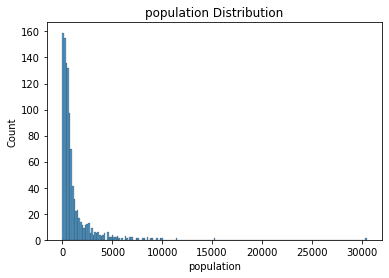

In [15]:
ax = sns.histplot(samples['population'].unique())
ax.set_xlabel('population')
ax.set_ylabel('Count')
ax.set_title('population Distribution')
ax

Imputation is very hard on this feature. A good solution would be to find the population records from 2014 and correct
the data manually. Another solution could be to search similar pumps on the same subvillages and impute use
the **mean or the median** of population (if exists), just like `amount_tsh`. From the above histogram, it seems that imputation should be done
by using the **median instead of the mean**, because **the variable is highly skewed**.

Text(0.5, 1.0, 'STD of Population per Subvillage')

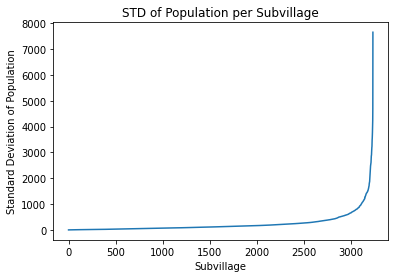

In [23]:
stds = set()
for subvillage in samples['subvillage'].unique():
    subvillage_samples = samples[samples['subvillage'] == subvillage]
    if subvillage_samples.shape[0] > 1:
        non_zeros = subvillage_samples['population'] > 0

        if sum(non_zeros):
            stds.add(np.std(subvillage_samples.loc[non_zeros, 'population']))

stds = np.array(sorted(stds))

ax = sns.lineplot(x=np.arange(stds.shape[0]), y=stds)
ax.set_xlabel('Subvillage')
ax.set_ylabel('Standard Deviation of Population')
ax.set_title('STD of Population per Subvillage')

# Public Meeting

The portion of pumps that were approved by a public meeting. As presented in the bar-plot below,
the majority of pumps were approved by a public meeting. **10%** of the pumps where not and this
value is unknown for a small portion of samples.

There is only a small percentage of missing values. However, "`public_meeting`" doesn't seem to be related with
any other variable on this dataset, so it could be either True or False. Best would be to create an "`unknown`"
category for the missing values.

Text(0.5, 1.0, 'Target Counts per Public Meeting')

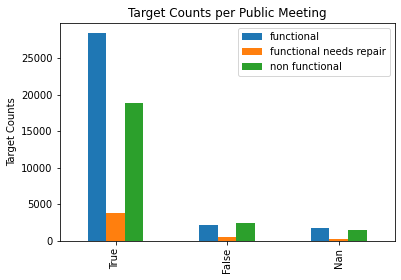

In [4]:
public_meeting_distributions = pd.DataFrame({
    'True': samples.loc[samples['public_meeting'] == True, 'targets'].value_counts(),
    'False': samples.loc[samples['public_meeting'] == False, 'targets'].value_counts(),
    'Nan': samples.loc[samples['public_meeting'].isna(), 'targets'].value_counts()
}).transpose()

ax = public_meeting_distributions.plot.bar()
ax.set_ylabel('Target Counts')
ax.set_title('Target Counts per Public Meeting')

# Permit

Whether the waterpoint is permitted. Just like "`public_meeting`", this feature also requires imputing.
The `nan` values should be treated just like the "`public_meeting`" variable.

Text(0.5, 1.0, 'Target Counts per Permit')

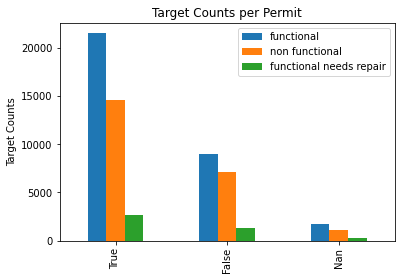

In [5]:
public_meeting_distributions = pd.DataFrame({
    'True': samples.loc[samples['permit'] == True, 'targets'].value_counts(),
    'False': samples.loc[samples['permit'] == False, 'targets'].value_counts(),
    'Nan': samples.loc[samples['permit'].isna(), 'targets'].value_counts()
}).transpose()

ax = public_meeting_distributions.plot.bar()
ax.set_ylabel('Target Counts')
ax.set_title('Target Counts per Permit')

# Recorded By

The group/company/organisation that registered this entry to the dataset. It contains only a value, which is "*GeoData Consultants Ltd*".
Since this feature contains no valuable information, it is removed from the dataset.

# Scheme Management & Scheme Name

The people who operate the waterpoint. `scheme_name` includes lots of unique and missing values. From the other hand,
the `scheme_management` variable includes only 11 unique values. There is one missing value named as "`None`", which can
easily be imputed by the nearest pump. Additionally, there are 3800 missing values. Some of them can be assigned the most
frequent value of the same subvillage or ward, if it exceeds a frequency threshold. The rest can be assigned with the "`unknown`"
category

<AxesSubplot:title={'center':'Scheme Management Distribution'}, xlabel='Count', ylabel='scheme_management'>

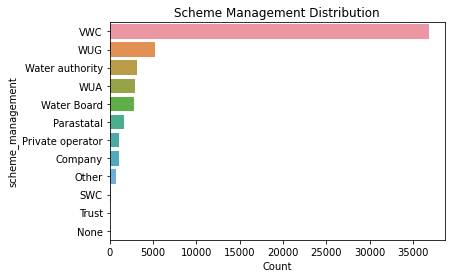

In [230]:
scheme_management_counts = samples['scheme_management'].value_counts()
ax = sns.barplot(y=scheme_management_counts.index, x=scheme_management_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('scheme_management')
ax.set_title('Scheme Management Distribution')
ax

# Management & Management Group

The people who manage the waterpoint. It contains 12 unique values with one of them being "*unknown*".

<AxesSubplot:title={'center':'Management Distribution'}, xlabel='Count', ylabel='management'>

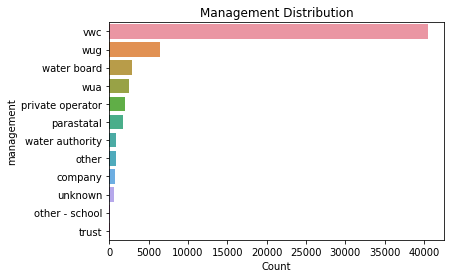

In [236]:
management_counts = samples['management'].value_counts()
ax = sns.barplot(y=management_counts.index, x=management_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('management')
ax.set_title('Management Distribution')
ax

<AxesSubplot:title={'center':'Management Group Distribution'}, xlabel='Count', ylabel='management_group'>

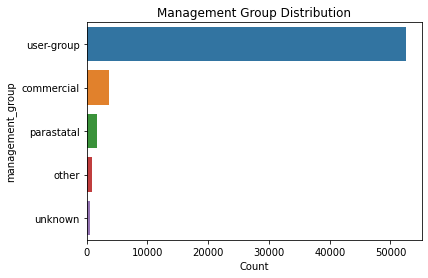

In [244]:
management_group_counts = samples['management_group'].value_counts()
ax = sns.barplot(y=management_group_counts.index, x=management_group_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('management_group')
ax.set_title('Management Group Distribution')
ax

# Extraction Type & Extraction Group Type/Class

The kind of extraction type that the waterpoint uses.

<AxesSubplot:title={'center':'Extraction Type Distribution'}, xlabel='Count', ylabel='extraction_type'>

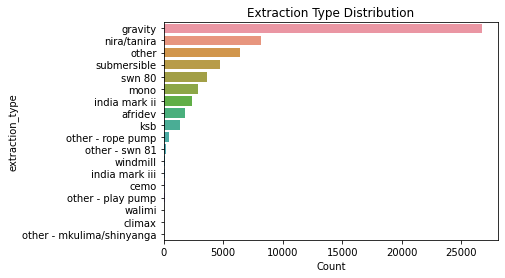

In [259]:
extraction_type_counts = samples['extraction_type'].value_counts()
ax = sns.barplot(y=extraction_type_counts.index, x=extraction_type_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('extraction_type')
ax.set_title('Extraction Type Distribution')
ax

<AxesSubplot:title={'center':'Extraction Type Class Distribution'}, xlabel='Count', ylabel='extraction_type_class'>

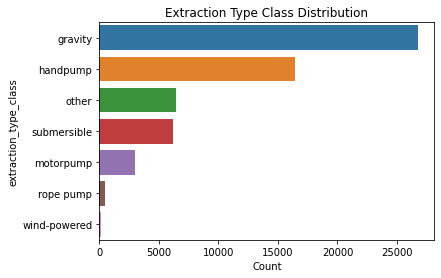

In [242]:
extraction_type_class_counts = samples['extraction_type_class'].value_counts()
ax = sns.barplot(y=extraction_type_class_counts.index, x=extraction_type_class_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('extraction_type_class')
ax.set_title('Extraction Type Class Distribution')
ax

# Payment & Payment Type

The payment policy of the waterpoint. Basically, this variable keeps track of the way payments are done.
The variables `payment` and `payment_type` are almost exactly the same with the only difference being the
naming of "*pay when scheme fails*" or ‘pay on failure’, which means the same thing. For that reason, only one of the two columns should be used on the dataset.

Almost **20%** of the samples consider "`unknown`" the payment policy. It should be best
to leave this feature as it is, to avoid the destruction of the distribution.

<AxesSubplot:title={'center':'Payment Distribution'}, xlabel='Count', ylabel='payment'>

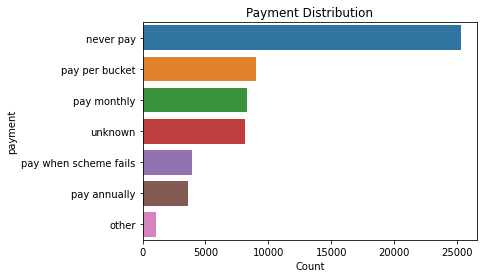

In [247]:
payment_counts = samples['payment'].value_counts()
ax = sns.barplot(y=payment_counts.index, x=payment_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('payment')
ax.set_title('Payment Distribution')
ax

# Water Quality & Quality Group

The quality of the groundwater. For most waterpoints **86%**, the quality is "*good*".
There are no particular issues with this variable so it should be left as it is.

<AxesSubplot:title={'center':'Water Quality Distribution'}, xlabel='Count', ylabel='water_quality'>

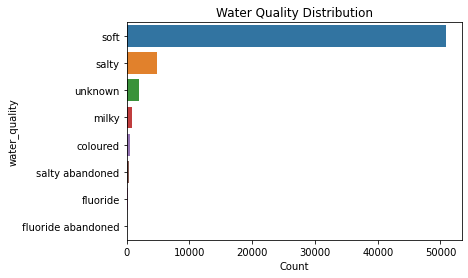

In [263]:
water_quality_counts = samples['water_quality'].value_counts()
ax = sns.barplot(y=water_quality_counts.index, x=water_quality_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('water_quality')
ax.set_title('Water Quality Distribution')
ax

# Quantity & Quantity Group

The quantity of water that passes from the waterpoint. Both variables (`quantity and quantity_group`) are exactly the same.

<AxesSubplot:title={'center':'Quantity Distribution'}, xlabel='Count', ylabel='quantity'>

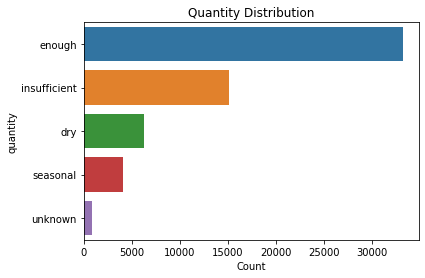

In [270]:
water_quality_counts = samples['quantity'].value_counts()
ax = sns.barplot(y=water_quality_counts.index, x=water_quality_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('quantity')
ax.set_title('Quantity Distribution')
ax

# Source & Source Type

The source of the water. No issues found with this feature and should be left as it is.

In [274]:
samples['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

# Waterpoint Type & Waterpoint Type Group

The type of waterpoint. There are 2 variables related to the type of water point: `waterpoint_type and waterpoint_type_group`. The
first one has 7 variables and the second one has 6. The only difference is the subdivision of category `communal standpipe` into 2
categories depending on if there are 1 or more standpipes. As this subdivision separates a substantial part of this dataset (**10%**),
the most detailed variable "`waterpoint_type`" should be kept.

<AxesSubplot:title={'center':'Waterpoint Type Distribution'}, xlabel='Count', ylabel='waterpoint_type'>

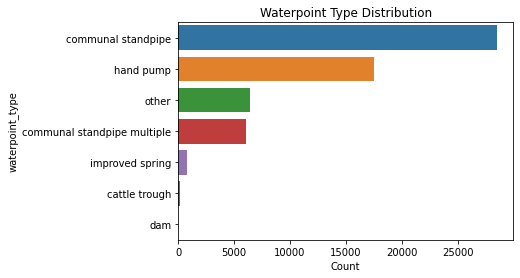

In [275]:
water_quality_counts = samples['waterpoint_type'].value_counts()
ax = sns.barplot(y=water_quality_counts.index, x=water_quality_counts.values)
ax.set_xlabel('Count')
ax.set_ylabel('waterpoint_type')
ax.set_title('Waterpoint Type Distribution')
ax